## Importing Libraries

In [6]:
%load_ext autoreload
%autoreload 2
# lib and settings for interactive plots
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)
    # figsize=(5, 4)
import matplotlib.pyplot as plt

import numpy as np
import math
import pandas as pd
from tensorflow import keras
import tensorflow_probability as tfp
from tensorflow.keras import layers
import keras.callbacks

from itertools import product
import os
base_folder = os.path.join(os.getcwd(), '..')

from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from pathlib import Path

## Function Definitions

In [7]:
def milstein_method(theta, sigma, delta_t, x0=1, N=1000):
    # TODO: check parameter mu
    X = np.zeros(N)
    X[0] = x0
    W = np.random.normal(0, 1, size=N)
    W[0] = 0
    for i in range(N-1):
        X[i+1] = X[i] + theta*(1 - X[i])*delta_t + sigma*W[i]*X[i]*np.sqrt(delta_t) + 0.5*(sigma**2)*X[i]*delta_t*(W[i]**2 - 1)
    return X

In [8]:
def plot_datapoints(grid, params, run=0, sigma=0.5,theta=0.1, delta=0.2, variation=None, num_run=10):
    assert run in range(params['run'])
    assert variation in list(params.keys())+[None]
    # TODO: prepare labels in function of different parameters in order to plot also the plot legend
    sigma = params['sigma'].index(sigma)
    theta = params['theta'].index(theta)
    delta = params['delta'].index(delta)
    plt.figure(figsize=figsize)
    if variation is None:
        Xs = grid[run, sigma, theta, delta, :]
        plt.plot(Xs)
    else:
        if variation == 'theta':
            Xs = grid[run, sigma, :, delta, :]
        elif variation == 'sigma':
            Xs = grid[run, :, theta, delta, :]
        elif variation == 'delta':
            Xs = grid[run, sigma, theta, :, :]
        elif variation == 'run':
            Xs = grid[:num_run, sigma, theta, delta, :]
        labels = [variation+' = '+str(p) for p in params[variation]]
        for X, l in zip(Xs, labels):
            plt.plot(X, label = l)
    plt.xlabel('t')
    plt.ylabel('X(t)')
    plt.legend()
    plt.show()


## Parameter grid

In [21]:
grid_path = os.path.join(base_folder, 'Data', 'grid')
params = {
        'run': 30,
        'sigma': [0.3, 0.4, 0.5, 0.6],
        'theta': [0.01, 0.1, 0.5, 3],
        # 'mu': [0.8, 0.9, 1, 1.1],
        'delta': [0.01,0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
        'N': 1000
    }
if not(Path(grid_path+'.npy').is_file()):
    grid = np.zeros((params['run'], 
                    len(params['sigma']),
                    len(params['theta']),
                    # len(params['mu']),
                    len(params['delta']),
                    params['N']))
    for r in tqdm(range(params['run'])):
        for s, t, d in product(params['sigma'], params['theta'],params['delta']):
            # TODO: just in case add also mu 
            si = params['sigma'].index(s)
            ti = params['theta'].index(t)
            di = params['delta'].index(d)
            grid[r,si,ti,di,:] = milstein_method(t,s,d)
    # store grid data
    np.save(grid_path, grid, allow_pickle=True)
grid = np.load(grid_path+'.npy', allow_pickle=True)

## first run varying sigma paramether and other paramether setted by default

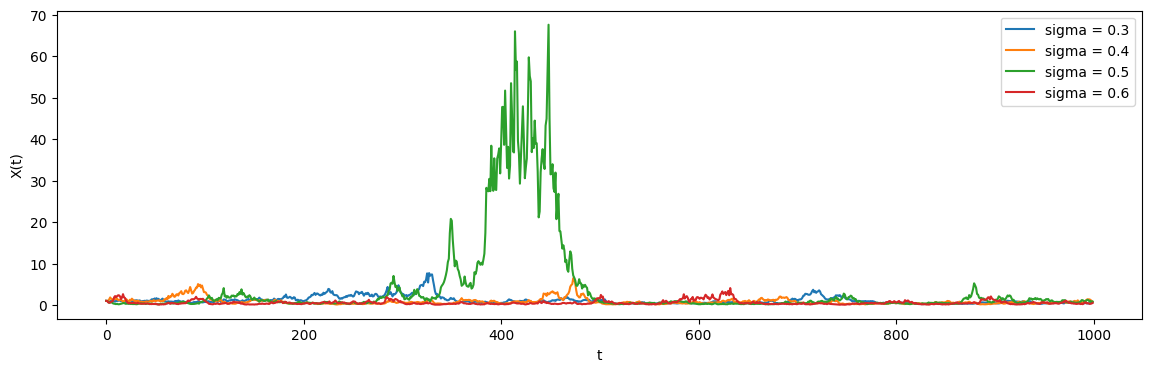

In [67]:
#
# plot_datapoints(grid, params, sigma=0.3, theta=0.01, delta=0.01, variation='sigma')
plot_datapoints(grid, params, run=0, variation='sigma')

## mean and dev std

In [15]:
# media su run
np.mean(grid, axis=0).shape
np.std(grid, axis=0).shape

(4, 4, 10, 1000)

In [16]:
# media su istanti temporali
np.mean(grid, axis=-1).shape
np.std(grid, axis=-1).shape

(30, 4, 4, 10)

In [58]:
#global_mean = np.mean(np.mean(grid, axis=0), axis=-1)
#global_std = np.std(np.std(grid, axis=0), axis=-1)

global_mean = np.mean(grid, axis=-1)
global_std = np.std(grid, axis=-1)

#global_mean = np.mean(grid, axis=0)
#global_std = np.std(grid,axis=0)
global_std.shape

(30, 4, 4, 10)

In [49]:
params

{'run': 30,
 'sigma': [0.3, 0.4, 0.5, 0.6],
 'theta': [0.01, 0.1, 0.5, 3],
 'delta': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
 'N': 1000}

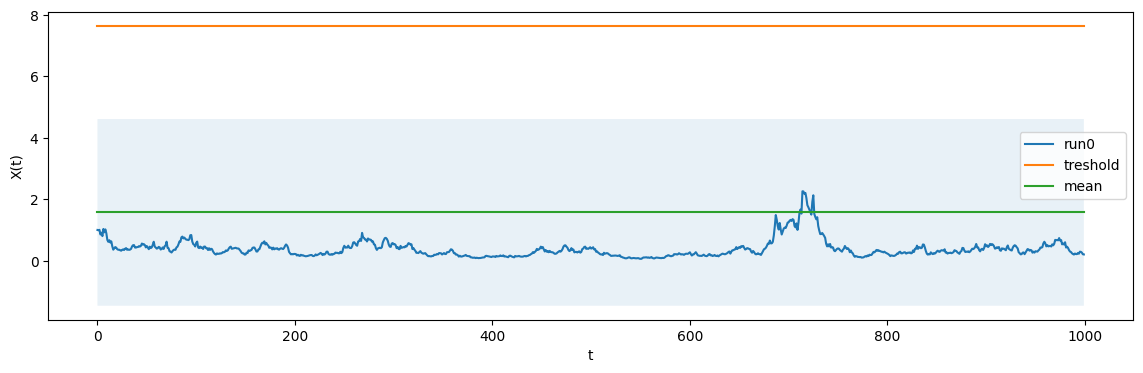

In [62]:
plt.figure(figsize=figsize)
plt.plot(grid[0,0,0,3,:], label='run0')
alpha = 2
#alpha = 1
run = 6
plt.plot([global_mean[run,0,0,3]+alpha*global_std[run,0,0,3] for _ in range(params['N'])] , label='treshold')
plt.plot([global_mean[run,0,0,3] for _ in range(params['N'])] , label='mean')
plt.fill_between(list(range(params['N']))
        ,[global_mean[run,0,0,3]+global_std[run,0,0,3] for _ in range(params['N'])],
         [global_mean[run,0,0,3]-global_std[run,0,0,3] for _ in range(params['N'])], alpha=0.1)
'''
plt.plot(global_mean[0,0,3,:]+alpha*global_std[0,0,3,:] , label='treshold')
plt.plot(global_mean[0,0,3,:], label='mean')
plt.fill_between(list(range(params['N']))
        ,global_mean[0,0,3,:]+global_std[0,0,3,:],
         global_mean[0,0,3,:]-global_std[0,0,3,:], alpha=0.1)
'''
plt.xlabel('t')
plt.ylabel('X(t)')
plt.legend()
plt.show()

In [ ]:
for r in tqdm(range(params['run'])):
        for s, t, d in product(params['sigma'], params['theta'],params['delta']):
            for time in range(params['N']):
            # TODO: just in case add also mu 
            si = params['sigma'].index(s)
            ti = params['theta'].index(t)
            di = params['delta'].index(d)
            grid[r,si,ti,di,:] = milstein_method(t,s,d)

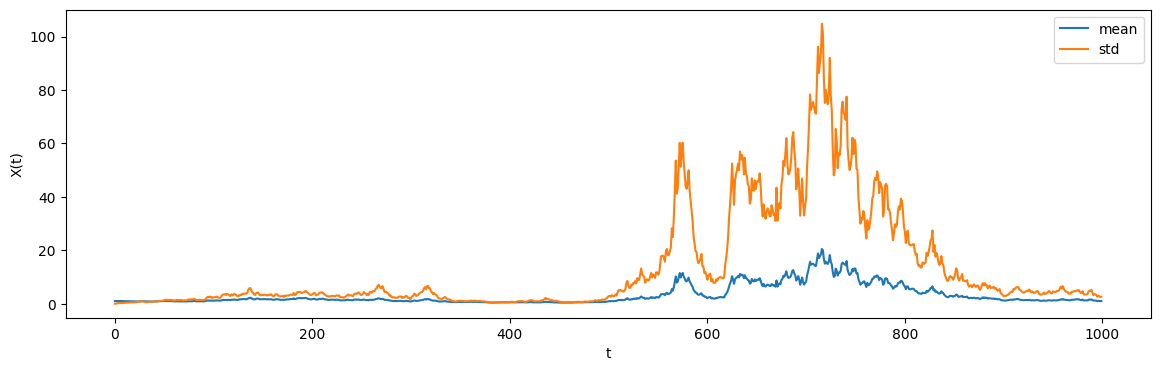

In [19]:
# np.mean(grid, axis=0)[0,0,:]
plt.figure(figsize=figsize)
plt.plot(np.mean(grid, axis=0)[0,0,3,:], label='mean')
plt.plot( np.std(grid, axis=0)[0,0,3,:], label='std')
plt.xlabel('t')
plt.ylabel('X(t)')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


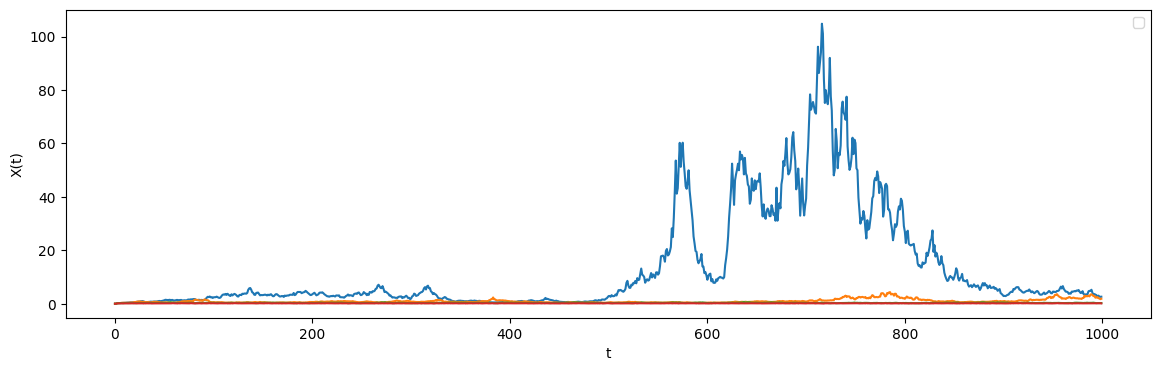

In [78]:
# np.mean(grid, axis=0)[0,0,:]
plt.figure(figsize=figsize)
plt.plot(np.std(grid, axis=0)[0,0,3,:])
plt.plot(np.std(grid, axis=0)[0,1,3,:])
plt.plot(np.std(grid, axis=0)[0,2,3,:])
plt.plot(np.std(grid, axis=0)[0,3,3,:])
plt.xlabel('t')
plt.ylabel('X(t)')
plt.legend()
plt.show()

L'istante di tempo non ci dice nulla sullo spike, ma ce lo dovrebbe dire l'istante precedente allo spike.

Se iniziano a crescere probabilmente c'è lo spike

In [ ]:
np.mean(grid, axis=-1)